In [1]:
import sys, os
import numpy as np

from scipy.optimize import minimize_scalar
from scipy.integrate import quad
import scipy.signal as sig
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

*Note.* For concreteness, we calculate the differential rate $dR/dq$ for fixed DM mass, coupling, and mediator mass. In principle, the code could be more efficient by performing calculations for different values of DM mass and coupling at the same time. This requires a few straightforward generalization of the functions defined below, but might need to carefully deal with numerical artifacts.

## Parameters

In [2]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

### Experiment parameters

In [5]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

### DM parameters

In [6]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0.0001      # Mediator mass, eV

In [7]:
M_X = M_X_in * 1e9   # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9   # eV
N_chi = M_X / m_chi  # Number of dark matter particles in the nugget

rhoDM = 0.3e9        # dark matter mass density, eV/cm^3

alpha_n = alpha_n_in # Dimensionless single neutron-nugget 
alpha = alpha_n * N_T # Coupling of the entire sphere
#mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

Some parameters related to DM velocity distribution.

In [8]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

## Defining functions

### Yukawa potential

In [9]:
def vtot(u, m_phi=m_phi, alpha=alpha):
    """Exact Yukawa potential for a uniform density sphere
    
    Parameters
    ----------
    u : float, array-like
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float, array-like
        Potential V(u) for each u in eV
    """
    mR = m_phi * R
    
    u = np.asarray(u)
    ret = np.empty_like(u)
    
    # Devide the array of u=1/r into three cases
    neg     = (u <= 0)   # ill-defined
    outside = (u < 1/R)  # ouside sphere
    inside  = (u >= 1/R) # inside sphere
    
    ret[neg] = np.inf
    
    # TODO: double check the formula for form factor
    if(mR > 0):   # massive mediator
        ret[outside] = 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u[outside]) * u[outside]
        ret[inside] = 3 * alpha/mR**3 * (m_phi - u[inside]*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u[inside])/np.sinh(mR)))
        
    else:         # massless mediator (alpha/r)
        ret[outside] = alpha * u[outside]
        ret[inside] = alpha/2 * (3/R - 1./(R**3 * u[inside]**2))

    return ret

Text(0, 0.5, 'v(r)')

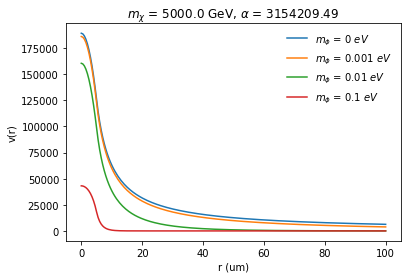

In [10]:
# Plotting the potential
r_um = np.linspace(1e-8, 100, 200)
r = r_um / hbarc # convert to eV

plt.plot(r_um, vtot(1/r, m_phi=0), label='$m_\phi$ = 0 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.001), label='$m_\phi$ = 0.001 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.01), label='$m_\phi$ = 0.01 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.1), label='$m_\phi$ = 0.1 $eV$')

plt.title(fr'$m_\chi$ = {M_X_in} GeV, $\alpha$ = {alpha:.2f}')
plt.legend(frameon=False)
plt.xlabel('r (um)')
plt.ylabel('v(r)')

### Scattering angle helper function
To calculate the scattering angle $\Theta$ as a function of DM energy $E$ and impact parameter $b$, we will use the following formula
$$
\begin{aligned}
    \Psi(b) &= \int_{r_\text{min}}^\infty \frac{(b/r^2) dr}{\sqrt{(1 - V(r)/E_\text{cm} - b^2/r^2)}} \\
              &= \int_0^{u_\text{max}} \frac{b du}{\sqrt{(1 - V(u)/E_\text{cm} - b^2u^2)}},
\end{aligned}
$$
where $\Psi$ is the change of angle when moving through the central force field and $E_\text{cm}$ is the total energy in the CM frame (equals to DM kinetic energy).

The scattering angle is
$$
    \Theta(b) = \pi - 2 \cdot \Psi(b).
$$
This is actually the scattering angle in the CM frame, but we assume the sphere is very heavy so it's the same as $\theta$, the scattering angle in the lab frame.

In [11]:
def get_integrand(E, u, b):
    """Integrand for calculating scattering angle as a function of b
    
    Parameters
    ----------
    E : float, array-like
        CM energy in eV
    u : float, array-like
        Distance inverse 1/r in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    float, m * n array
        Integrand value. m = dim(E), n = dim(u), k = dim(b)
    """
    # Thsi might be a little tricky to implement, so we'll see how it goes 
    pass

In [22]:
#### BELOW TO BE ORGANIZED
## integrand needed for finding the scattering angle as a function of impact parameter
def integ(u, b, E):

    sval = 1 - vtot(u)/E - (b*u)**2
    #print(u,b,E,vtot(u)/E, b*u, sval)
    if(sval >= 0):
        integ = b/np.sqrt(sval)
    else:
        integ = 0
    return integ

def integ_out(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
        else:
            sval = alpha * u
    return b/np.sqrt(1 - sval/E - (b*u)**2)

def integ_in(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))
        else:
            sval = alpha/2 * (3/R - 1./(R**3 * u**2))
    return b/np.sqrt(1 - sval/E - (b*u)**2)

### Other functions

In [12]:
def max_u_exact(E, b, m_phi=m_phi, alpha=alpha):
    """Exact value of maximum u (minimum r) during the scattering
    
    Parameters
    ----------
    E : float, array-like
        CM energy in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    m * n array
        Max u value. m = dim(E), n = dim(b)
    """
    mR = m_phi * R
    
    E, b = np.asarray(E), np.asarray(b)
    EE, bb = np.meshgrid(E, b)
    
    min_r = np.empty_like(EE)
    
    inside  = (bb < R)
    outside = (bb >= R)
    
    # TODO
    # It seems like the formula breaks down when E is relatively small
    # Might want to deal with the issue here
    if mR > 0:  # massive mediator
        min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
        min_r[outside] = bb[outside] * np.sqrt(EE[outside])/np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))
    else:       # massless mediator TODO
        pass
    
    return 1./min_r

### Other functions (not organized yet)

In [14]:
## function to numerically find the maximum value of u = 1/r, not used currently
def minr_func(u,b,E):
    return np.abs( 1 - (b*u)**2 - vtot(u)/E)

#  analyitical formula for finding the maximum value of u = 1/r
def min_u_exact(b, E):
    if b < R:
        outval = b*np.sqrt(E)/np.sqrt(E - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*b)/np.sinh(mR))/(b*(1+1/np.tanh(mR))))))
    else:
        outval = b*np.sqrt(E)/np.sqrt(E - (3*alpha*np.exp(-m_phi*b))/(b * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))
    return 1./outval

def get_color_map(n):
    jet = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=n-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    outmap = []
    for i in range(n):
        outmap.append( scalarMap.to_rgba(i) )
    return outmap

## function used to smear the spectrum with gaussian resolution
def res_fun( x, sig ):
    return 1.0/(sig * np.sqrt(2*np.pi)) * np.exp(-0.5*(x/sig)**2)

## Calculate the differential cross section $\frac{d\sigma}{dq}$
Possible ways to vectorize the numerical integration:
`scipy.integrate.quad_vec()`.
see https://stackoverflow.com/questions/32539106/vectorize-scipy-integrate-quad

In [17]:
nvels = 100      # number of velocities to include in integration
v = np.linspace(vmin, vesc, nvels)
pmax = np.max((vesc * M_X, 10e9))
cmap = get_color_map(nvels)

# make a list of impact parameters over which to calculate the scattering angle
if(m_phi > 0):
    b_um = np.logspace(-3, 3, 2000)
else:
    b_um = np.logspace(-3, 5, 2000)

In [26]:
p = M_X * v            # DM initial momentum (eV), 1*dim(v) array
E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle, 1*dim(v) array

b = b_um / hbarc       # Impact factor (eV^-1)

In [19]:
# Distance of shortest approach (maximum u)
# For some b's, the analytic formula breaks down at the first 13 small velocities
# I think we can just throw them away
max_u = max_u_exact(E, b)

C:\Users\yuhan\AppData\Local\Temp\ipykernel_9244\1568089994.py:30: RuntimeWarning: invalid value encountered in sqrt
  min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
C:\Users\yuhan\AppData\Local\Temp\ipykernel_9244\1568089994.py:31: RuntimeWarning: invalid value encountered in sqrt
  min_r[outside] = bb[outside] * np.sqrt(EE[outside])/np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))


Now do numerical integration to find the scattering angle

In [21]:
max_u[0]

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,  43.8590745 ,  79.50134154,  99.98736628,
       114.47102675, 125.50388769, 134.26208244, 141.40581691,
       147.34843478, 152.36744358, 156.65845784, 160.36443371,
       163.5928045 , 166.42613467, 168.92905527, 171.15294798,
       173.13920555, 174.92155908, 176.52777517, 177.9809165 ,
       179.30029325, 180.50219138, 181.6004371 , 182.60683936,
       183.53154016, 184.38329448, 185.16969587, 185.89735961,
       186.57207246, 187.19891596, 187.78236851, 188.3263904 ,
       188.83449496, 189.30980851, 189.75512091, 190.17292859,
       190.56547116, 190.93476279, 191.28261914, 191.61068061,
       191.92043236, 192.21322183, 192.49027381, 192.7527038 ,
       193.00152948, 193.23768098, 193.46200976, 193.67529656,
       193.87825834, 194.07155449, 194.2557923 , 194.43

In [23]:
b

array([5.00000000e-03, 5.03467574e-03, 5.06959197e-03, ...,
       4.93136335e+03, 4.96556308e+03, 5.00000000e+03])

In [27]:
for b_ in b[0:4]:
    for E_ in E[0:4]:
        print(b_, E_)

0.005 6250.0
0.005 11501.68987858382
0.005 18342.61810019386
0.005 26772.78466483013
0.005034675742081855 6250.0
0.005034675742081855 11501.68987858382
0.005034675742081855 18342.61810019386
0.005034675742081855 26772.78466483013
0.005069591965581496 6250.0
0.005069591965581496 11501.68987858382
0.005069591965581496 18342.61810019386
0.005069591965581496 26772.78466483013
0.005104750338273245 6250.0
0.005104750338273245 11501.68987858382
0.005104750338273245 18342.61810019386
0.005104750338273245 26772.78466483013


In [ ]:
## split the integral into two pieces, to handle the diverging piece only over a small range
## this substantially improves the performance of quad
int_res1 = quad(integ, min_u/1e7, min_u*0.9, args=(b,E)) #, limit=1000, full_output=1)
int_res2 = quad(integ, min_u*0.9, min_u, args=(b,E)) #, limit=1000, full_output=1)
int_res = int_res1[0] + int_res2[0]